# 1. 绪论

In [2]:
# preparation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prml.preprocess import PolynomialFeature
from prml.linear import (
    LinearRegression,
    RidgeRegression,
    BayesianRegression
)

np.random.seed(1234)

## 1.1. Example: Polynomial Curve Fitting

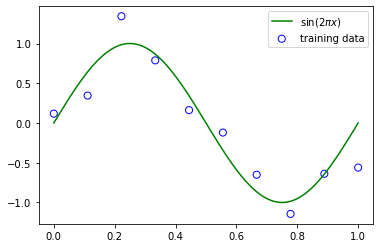

In [4]:
# sample data
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

多项式拟合：<p>
    $y(x,w)=w_0+w_1x+w_2x^2+...+w_Mx^M=\sum_{j=0}^M {w_jx^j} \tag{1.1}$ 

误差函数<p>
$E(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \boldsymbol{w}\right)-t_{n}\right\}^{2} \tag{1.2}$<p>
目标是让误差函数越来越小。有唯一解$w^*$,是的$E(w)$取得最小值$E(w^*)$。

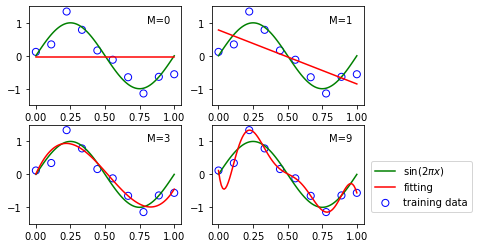

In [17]:
# 几个多项式拟合
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeature(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(0.8, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=0, borderaxespad=0.)
plt.show()

m太大发生过拟合，泛化性能下降。需要一个衡量模型泛化能力的标准。

为了比较不同大小的数据集和保证和t有相同单位。引入均方根误差：<p>
    $E_{R M S}=\sqrt{2 E\left(\boldsymbol{w}^{*}\right) / N} \tag{1.3}$

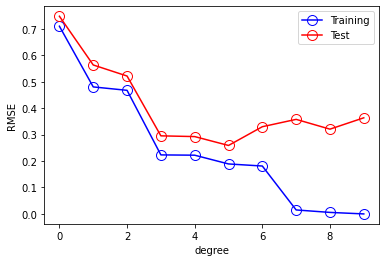

In [18]:
# 均方根对比
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(10):
    feature = PolynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()

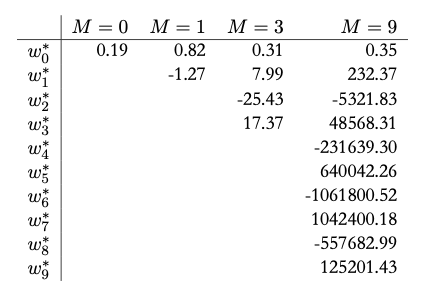

增加样本个数<p>
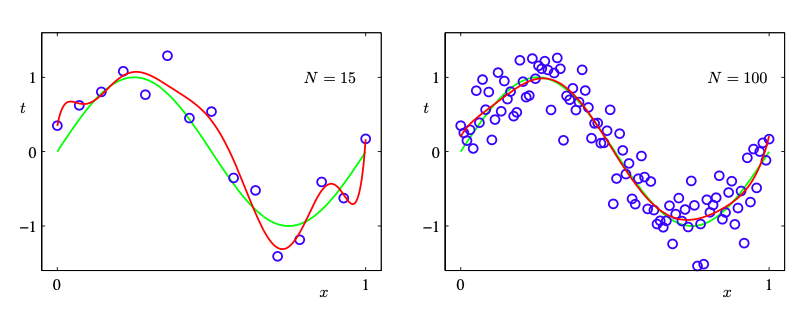

正则化
$\tilde{E}(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \boldsymbol{w}\right)-t_{n}\right\}^{2}+\frac{\lambda}{2}\|\boldsymbol{w}\|^{2} \tag{1.4}$
$\|\boldsymbol{w}\|^{2}\equiv=\boldsymbol{w}_0^2+\boldsymbol{w}_1^2+...+\boldsymbol{w}_M^2$，$\lambda$的大小控制的正则化影响的大小

# 1.2 概率论

sum rule $p(X)=\sum_{Y}p(X,Y) \tag{1.10}$ <p>
product rule $p(X,Y)=P(Y|X)p(X) \tag{1.10}$